In [17]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as tfs
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader

In [18]:
plt.style.use('default')
sns.set(rc={'figure.figsize':(8, 6)})
sns.set_style('white')
sns.despine()

<Figure size 800x600 with 0 Axes>

In [2]:
data_train = pd.read_csv('/content/mnist_train.csv')
data_test = pd.read_csv('/content/mnist_test.csv')

In [3]:
data = pd.DataFrame()
data = data.append(data_train)
data = data.append(data_test)

In [4]:
data = data.sample(frac=1).reset_index()
data.drop(columns={'index'})

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69997,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
69998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = torch.tensor(X.values)
        self.y = torch.tensor(y.values) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

def create_datasets(data, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    num_train = int(len(data)*p_train)
    num_val = int(len(data)*p_val)
    num_test = int(len(data)*p_test)

    data_train = data[:num_train].drop(columns='index')
    data_valid = data[num_train:num_train+num_val].drop(columns='index')
    data_test = data[-num_test:].drop(columns='index')

    X_train, y_train = data_train.drop(columns='label'), data_train['label']
    X_val, y_val = data_valid.drop(columns='label'), data_valid['label']
    X_test, y_test = data_test.drop(columns='label'), data_test['label']

    data_train = dataset_class(X_train, y_train)
    data_valid = dataset_class(X_val, y_val)
    data_test = dataset_class(X_test, y_test)

    return data_train, data_valid, data_test

In [6]:
data_train, data_valid, data_test = create_datasets(data, Dataset)

In [7]:
batch_size = 64

train_dataloader = DataLoader(data_train, 
                              batch_size=batch_size,
                              drop_last=True)
valid_dataloader = DataLoader(data_valid, 
                              batch_size=batch_size,
                              drop_last=True)
test_dataloader = DataLoader(data_test, 
                              batch_size=batch_size,
                             drop_last=True)

In [8]:
loaders = {'train': train_dataloader, 'valid': valid_dataloader}

In [9]:
import torch
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    
    def forward(self, x):
        x = x.type(torch.float32)
        x = x.view(batch_size, 1, 28, 28)

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

net = Net()
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
# hyper parameters
max_epoch = 10

# loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
accuracy = {'train': [], 'valid': []}

for epoch in range(max_epoch):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == 'train':
                net.train()
                output = net.forward(x_batch)
                loss = criterion(output, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                net.eval()
                with torch.no_grad():
                    output = net.forward(x_batch)
            preds = output.argmax(-1)
            all = batch_size
            correct = torch.tensor(y_batch[y_batch==preds].size()) 
            epoch_correct += correct.item()
            epoch_all += all
        if k == 'train':
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8773214285714286
Loader: valid. Accuracy: 0.9478211009174312
Epoch: 2
Loader: train. Accuracy: 0.9595
Loader: valid. Accuracy: 0.9661697247706422
Epoch: 3
Loader: train. Accuracy: 0.9710714285714286
Loader: valid. Accuracy: 0.9697534403669725
Epoch: 4
Loader: train. Accuracy: 0.9772142857142857
Loader: valid. Accuracy: 0.9747706422018348
Epoch: 5
Loader: train. Accuracy: 0.9805535714285715
Loader: valid. Accuracy: 0.9782110091743119
Epoch: 6
Loader: train. Accuracy: 0.9833392857142857
Loader: valid. Accuracy: 0.9795011467889908
Epoch: 7
Loader: train. Accuracy: 0.9862321428571429
Loader: valid. Accuracy: 0.9795011467889908
Epoch: 8
Loader: train. Accuracy: 0.9885178571428571
Loader: valid. Accuracy: 0.9812213302752294
Epoch: 9
Loader: train. Accuracy: 0.9902321428571429
Loader: valid. Accuracy: 0.9806479357798165
Epoch: 10
Loader: train. Accuracy: 0.9918392857142857
Loader: valid. Accuracy: 0.9807912844036697


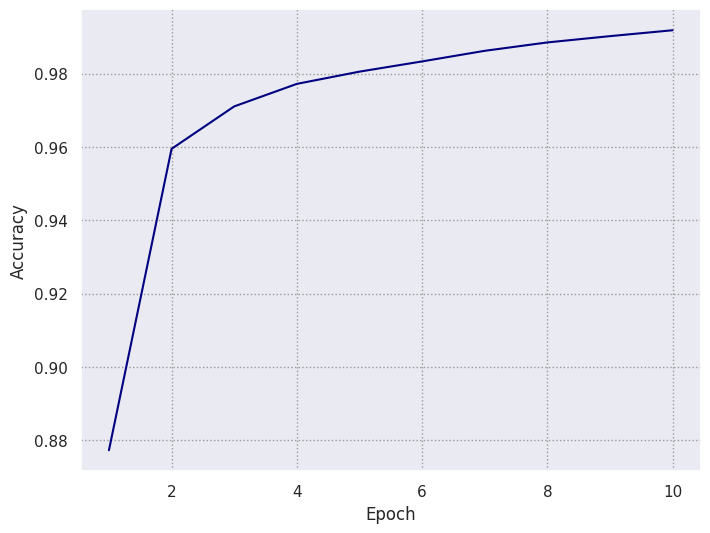

In [25]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], accuracy['train'], color='navy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()